<a href="https://colab.research.google.com/github/morris198/Movie/blob/main/momentun_bot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[*********************100%***********************]  1 of 1 completed


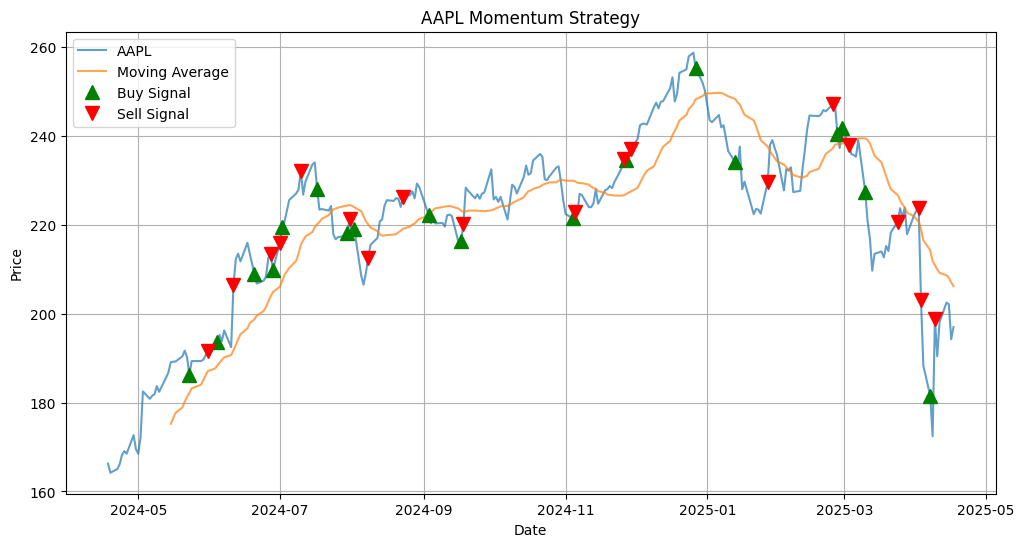

In [ ]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np # Import numpy

def fetch_data(ticker, period="1y", interval="1d"):
    """Fetches historical price data for a given ticker."""
    data = yf.download(ticker, period=period, interval=interval)
    return data['Close']

def calculate_moving_average(prices, window=20):
    """Calculates the simple moving average."""
    return prices.rolling(window=window).mean()

def calculate_rsi(prices, period=14):
    """Calculates the Relative Strength Index."""
    delta = prices.diff(1).dropna()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    avg_gain = gain.rolling(window=period).mean()
    avg_loss = loss.rolling(window=period).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def trading_signals(prices, ma, rsi_values=None, rsi_threshold_low=30, rsi_threshold_high=70):
    """Generates buy and sell signals based on the momentum strategy and optional RSI filter."""
    signals = pd.DataFrame(index=prices.index)
    signals['price'] = prices
    signals['moving_average'] = ma
    signals['signal'] = 0.0

    # Generate buy/sell signals based on moving average crossover
    signals['signal'] = np.where(signals['price'] > signals['moving_average'], 1.0, 0.0)
    signals['positions'] = signals['signal'].diff()

    # Apply RSI filter if RSI values are provided
    if rsi_values is not None:
        signals['rsi'] = rsi_values
        # Only buy if price is above MA AND RSI is not overbought
        signals['signal'] = np.where((signals['price'] > signals['moving_average']) & (signals['rsi'] < rsi_threshold_high), 1.0, 0.0)
        # Only sell if price is below MA AND RSI is not oversold (optional, can be removed)
        signals['signal'] = np.where((signals['price'] < signals['moving_average']) & (signals['rsi'] > rsi_threshold_low), -1.0, signals['signal'])
        signals['positions'] = signals['signal'].diff()

    return signals

def plot_signals(signals, ticker):
    """Plots the price data, moving average, and trading signals."""
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(signals['price'], label=ticker, alpha=0.7)
    ax.plot(signals['moving_average'], label='Moving Average', alpha=0.7)
    ax.plot(signals[signals['positions'] == 1].index, signals['price'][signals['positions'] == 1], '^', markersize=10, color='g', label='Buy Signal')
    ax.plot(signals[signals['positions'] == -1].index, signals['price'][signals['positions'] == -1], 'v', markersize=10, color='r', label='Sell Signal')
    ax.set_title(f'{ticker} Momentum Strategy')
    ax.set_xlabel('Date')
    ax.set_ylabel('Price')
    ax.legend()
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    ticker = "AAPL"  # You can change this to any stock ticker
    data = fetch_data(ticker)
    ma = calculate_moving_average(data)
    rsi = calculate_rsi(data)
    signals = trading_signals(data, ma, rsi_values=rsi)
    plot_signals(signals, ticker)